# PySpark data analysis
Based on [this post](https://towardsdatascience.com/beginners-guide-to-pyspark-bbe3b553b79f).

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, lit, countDistinct

In [3]:
spark = SparkSession.builder\
        .master("spark://dankpad:7077")\
        .appName("pyspark-data-analysis")\
        .getOrCreate()

### Loading and analysing data structure

In [4]:
# Loading a csv
rdd_csv = spark.read.csv("./data/stocks_price_final.csv", sep = ",", header = True)

In [5]:
# Counting number of records
rdd_csv.count()

1729034

In [6]:
# Printing columns and data types identified
rdd_csv.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- symbol: string (nullable = true)
 |-- date: string (nullable = true)
 |-- open: string (nullable = true)
 |-- high: string (nullable = true)
 |-- low: string (nullable = true)
 |-- close: string (nullable = true)
 |-- volume: string (nullable = true)
 |-- adjusted: string (nullable = true)
 |-- market.cap: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- exchange: string (nullable = true)



In [7]:
# Creating the schema to be used for the RRD during file loading
schema = [
    StructField('_c0', IntegerType(), True),
    StructField('symbol', StringType(), True),
    StructField('date', DateType(), True),
    StructField('open', DoubleType(), True),
    StructField('high', DoubleType(), True),
    StructField('low', DoubleType(), True),
    StructField('close', DoubleType(), True),
    StructField('volume', IntegerType(), True),
    StructField('adjusted', DoubleType(), True),
    StructField('market.cap', StringType(), True),
    StructField('sector', StringType(), True),
    StructField('industry', StringType(), True),
    StructField('exchange', StringType(), True),
]

structure = StructType(fields = schema)

In [8]:
# Loading a csv specifying schema
rdd_csv = spark.read.csv("./data/stocks_price_final.csv", sep = ",", header = True, schema = structure )

In [9]:
# Printing columns and data types identified, you can also use .schema, .dtypes, .columns
rdd_csv.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- symbol: string (nullable = true)
 |-- date: date (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: integer (nullable = true)
 |-- adjusted: double (nullable = true)
 |-- market.cap: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- exchange: string (nullable = true)



In [10]:
# Printing the first 20 records, you can also use .take(n), .head(n), .first()
rdd_csv.show()

+---+------+----------+---------+---------+---------+---------+-------+---------+----------+-------------+--------------------+--------+
|_c0|symbol|      date|     open|     high|      low|    close| volume| adjusted|market.cap|       sector|            industry|exchange|
+---+------+----------+---------+---------+---------+---------+-------+---------+----------+-------------+--------------------+--------+
|  1|   TXG|2019-09-12|     54.0|     58.0|     51.0|    52.75|7326300|    52.75|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  2|   TXG|2019-09-13|    52.75|   54.355|49.150002|    52.27|1025200|    52.27|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  3|   TXG|2019-09-16|52.450001|     56.0|52.009998|55.200001| 269900|55.200001|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  4|   TXG|2019-09-17|56.209999|60.900002|   55.423|56.779999| 602800|56.779999|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  5|   TXG|2019-09-18|56.849998|    62.2

### Querying and visualizing data

In [11]:
# Filtering data
# Transforming to pandas is important for visualization purposes using matplotlib
TSLA = rdd_csv.filter(col("symbol") == lit("TSLA")).toPandas()
GME = rdd_csv.filter(col("symbol") == lit("GME")).toPandas()

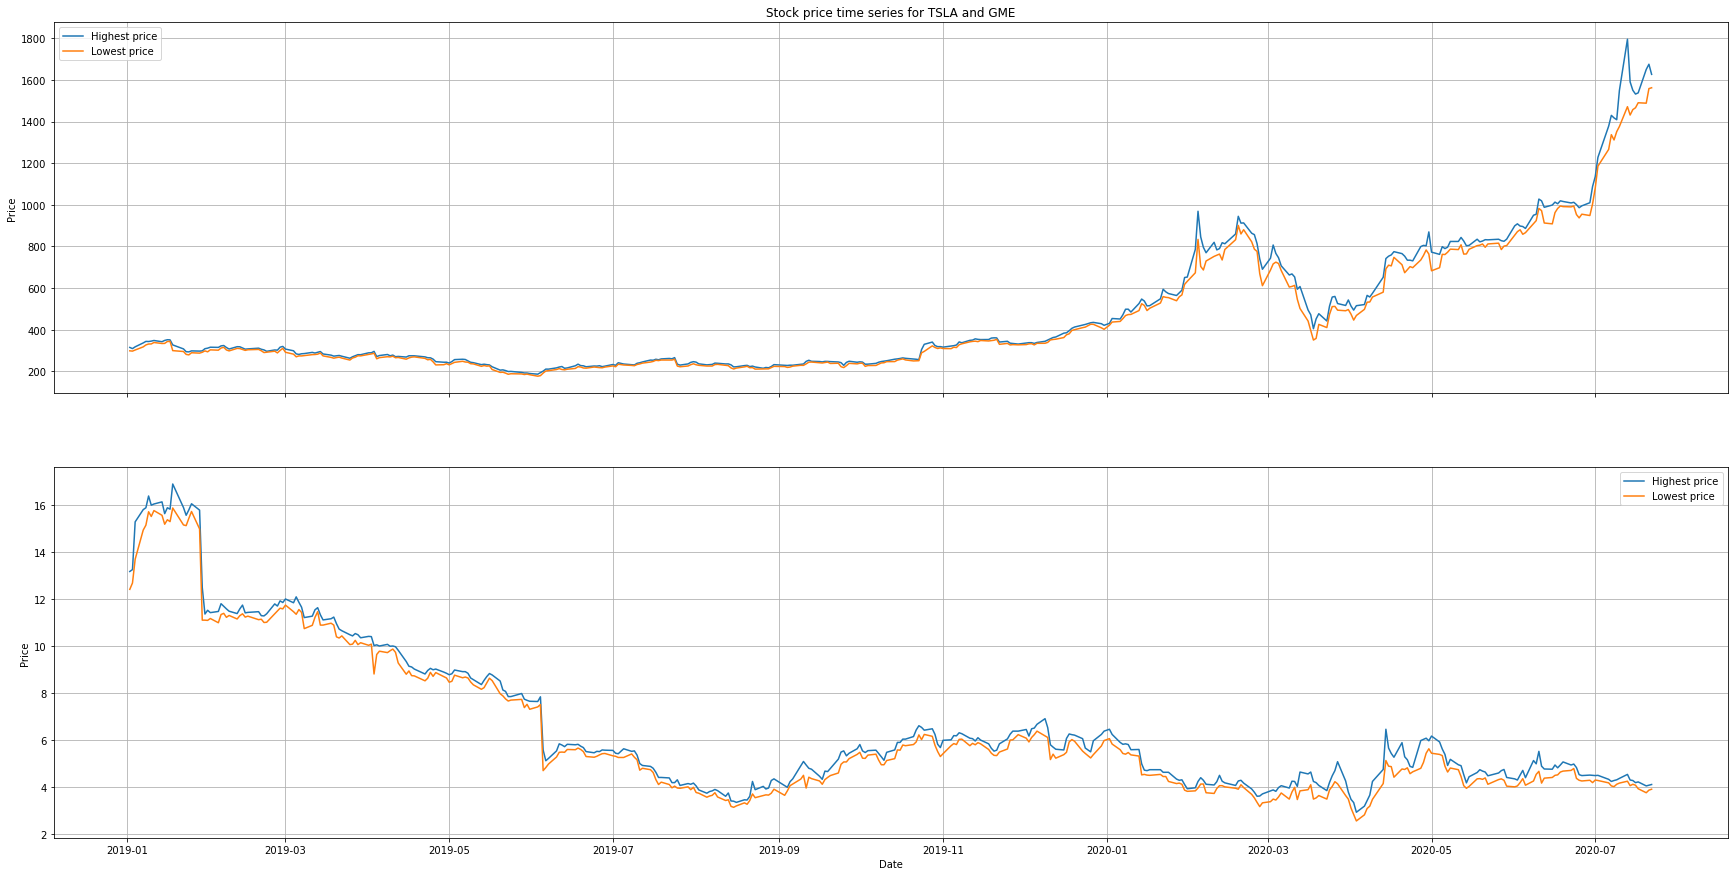

In [12]:
fig, axes = plt.subplots(2, 1, sharex = True, figsize = (30, 15))
axes[0].plot(TSLA["date"], TSLA["high"], label = "Highest price")
axes[0].plot(TSLA["date"], TSLA["low"], label = "Lowest price")
axes[1].plot(GME["date"], GME["high"], label = "Highest price")
axes[1].plot(GME["date"], GME["low"], label = "Lowest price")
axes[0].set_title("Stock price time series for TSLA and GME")
axes[0].set_ylabel("Price")
axes[1].set_ylabel("Price")
plt.xlabel("Date")
axes[0].grid()
axes[1].grid()
axes[0].legend()
axes[1].legend()

In [13]:
ncomp_by_sector = rdd_csv.select(["symbol", "sector"]).groupBy("sector").agg(countDistinct("symbol").alias("n_companies")).orderBy(col("n_companies")).toPandas()

<BarContainer object of 12 artists>

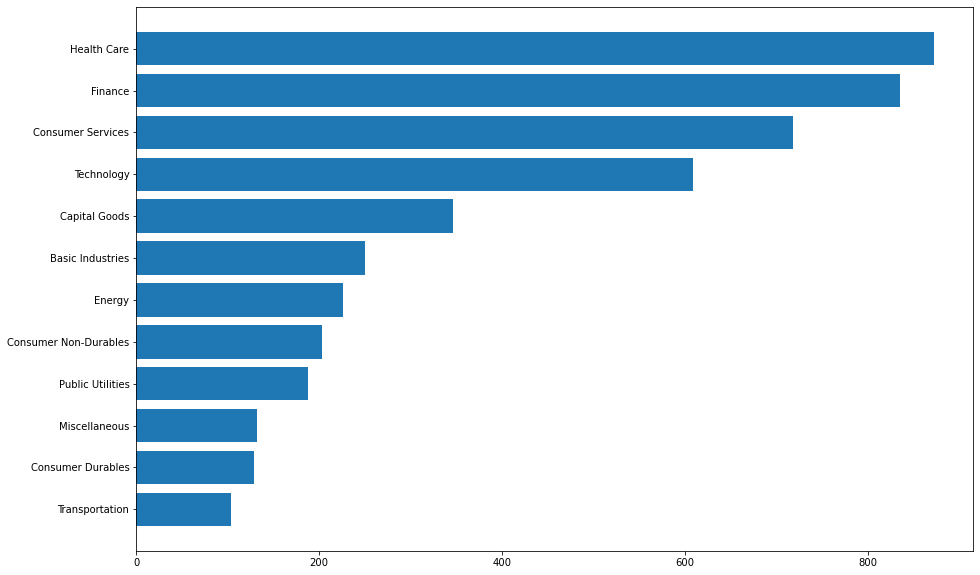

In [14]:
plt.figure(figsize = (15, 10))
plt.barh(ncomp_by_sector["sector"], ncomp_by_sector["n_companies"])

### Storing data

In [15]:
# Storing data in JSON format
rdd_csv.filter(col("symbol") == lit("TSLA")).select(["date", "high", "low"]).write.save("./data/TSLA_timeseries.csv", format = "csv", header = "true")

### Stoping Spark context and session

In [16]:
spark.stop()